#Travailler avec des valeurs aberrantes

Une valeur aberrante est un point de données qui est significativement différent des données restantes. Les paramètres statistiques tels que la moyenne et la variance sont sensibles aux valeurs aberrantes. Les valeurs aberrantes peuvent également affecter les performances de certains modèles d'apprentissage automatique, tels que la régression linéaire ou AdaBoost. Par conséquent, nous pouvons vouloir supprimer ou concevoir les valeurs aberrantes dans les variables de notre ensemble de données.

Comment pouvons-nous concevoir des valeurs aberrantes ? Une façon de gérer les valeurs aberrantes consiste à effectuer une discrétisation des variables. Avec la discrétisation, les valeurs aberrantes tomberont dans les intervalles inférieurs ou supérieurs et, par conséquent, seront traitées comme les valeurs inférieures ou supérieures restantes de la variable. Une autre façon de traiter les valeurs aberrantes consiste à supposer que l'information est manquante, à traiter les valeurs aberrantes avec les données manquantes restantes et à appliquer l'une des techniques d'imputation des valeurs manquantes. Nous pouvons également supprimer les observations avec des valeurs aberrantes de l'ensemble de données, ou plafonner les valeurs maximales et minimales des variables, comme nous le verrons tout au long de cet article.

Dans cet article, nous verrons comment identifier et supprimer les valeurs aberrantes d'un ensemble de données, et comment remplacer les valeurs aberrantes par des valeurs maximales ou minimales. Nous discuterons également de la manière d'utiliser la moyenne et l'écart type pour les variables normalement distribuées ou l'intervalle interquartile pour les caractéristiques asymétriques ou en utilisant des centiles. 

Ce chapitre couvrira les recettes suivantes: 
* (Trimming) Détecter et exclure les valeurs aberrantes de l'ensemble de données
* Effectuer la winsorisation
* Plafonnement de la variable à des valeurs maximales et minimales arbitraires



## (Trimming) Détecter et exclure les valeurs aberrantes

Trimming est le processus de suppression des observations qui montrent des valeurs aberrantes dans une ou plusieurs variables de l'ensemble de données. Il existe trois méthodes couramment utilisées pour définir les limites au-delà desquelles une valeur peut être considérée comme une valeur aberrante. Si la variable est normalement distribuée, les limites sont données par la moyenne plus ou moins trois fois l'écart-type, car environ 99 % des données seront distribuées entre ces limites. Pour les variables distribuées normalement, ainsi que pas normalement, nous pouvons déterminer les limites en utilisant les règles de proximité de l'intervalle interquartile ou en fixant directement les limites aux 5e et 95e quantiles. Prévoir les problèmes de variables dans la création de modèles ML. Dans cette recette, nous allons utiliser les trois mesures pour identifier puis supprimer les valeurs aberrantes dans l'ensemble de données Boston House Prices de scikit-learn, en utilisant pandas et NumPy

In [25]:
#Commençons par importer les bibliothèques Python nécessaires
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# boston house dataset for the demo
from sklearn.datasets import load_boston

In [26]:
#Chargeons l'ensemble de données sur les prix des maisons de Boston à partir de scikit-learn 

# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()

# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


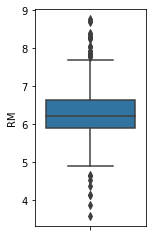

In [27]:
# Faisons une boîte à moustaches de la variable RM pour visualiser les valeurs aberrantes :
plt.figure(figsize=(2, 4))
sns.boxplot(y=boston['RM'])

Les valeurs aberrantes sont les astérisques situés à l'extérieur des moustaches, qui délimitent les limites de la règle de proximité interquartile

Créons une fonction pour trouver les limites d'une distribution variable, en utilisant la règle de proximité inter-quartile

In [28]:
def find_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [29]:
# Utilisons la fonction de pour déterminer les limites de la variable RM
# find limits for RM
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [30]:
# Créons un vecteur booléen pour signaler les valeurs aberrantes dans RM
# let's flag the outliers in the data set

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [31]:
#Enfin, supprimons les valeurs aberrantes de l'ensemble de données
# let's trimm the dataset only of outliers in RM

boston_trimmed = boston.loc[~outliers_RM ]

boston.shape, boston_trimmed.shape

((506, 3), (476, 3))

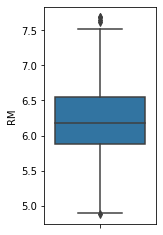

In [32]:
plt.figure(figsize=(2, 4))
sns.boxplot(y=boston_trimmed['RM'])

Si au lieu d'utiliser la règle de proximité de l'intervalle interquartile, nous voulons utiliser la moyenne et l'écart type pour trouver les limites, nous devons remplacer le code dans la fonction find_boundaries

In [33]:
# Trouver les limites des valeurs aberrantes en utilisant la moyenne et l'écart type
def find_boundaries(df, variable, distance):
    lower_boundary = df[variable].mean() - (df[variable].std() * distance)
    upper_boundary = df[variable].mean() + (df[variable].std() * distance)
    return upper_boundary, lower_boundary

In [34]:
# Calculez les limites de RM :
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 3)
RM_upper_limit, RM_lower_limit

(8.392485817597757, 4.176782957105816)


Alternativement, si nous voulons utiliser des quantiles pour calculer les limites, nous devons écrire la fonction comme à l'étape suivante

In [35]:
# Trouver les limites des valeurs aberrantes à l'aide de quantiles
def find_boundaries(df, variable):
    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [36]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM')
RM_upper_limit, RM_lower_limit

(7.5875, 5.314)

Dans cette recette, nous avons supprimé les valeurs aberrantes d'une variable de l'ensemble de données Boston House Prices de scikit-learn. Pour supprimer les valeurs aberrantes, nous avons d'abord identifié ces valeurs visuellement via un boxplot. Ensuite, nous avons créé une fonction pour trouver les limites dans lesquelles nous avons trouvé la majorité des valeurs de la variable. Ensuite, nous avons créé un vecteur booléen pour signaler les valeurs de la variable qui se situent au-delà de ces limites, et, enfin, nous avons supprimé ces observations de l'ensemble de données
